In [1]:
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import read_montage

import pandas as pd
import numpy as np

from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt
from mne import Epochs, find_events

%matplotlib inline

## Read data and convert them in MNE objects

Data are saved in csv file for more convinience. here we will convert them in MNE data object so we can pre-process and epoch them

In [2]:
all_epochs = []
subjects = [1, 2]

for subject in subjects:
    fnames = glob('../data/visual/P300/subject%d/session*/data_*.csv' % (subject))
    raw = []
    for fname in fnames:
        # read the file
        data = pd.read_csv(fname, index_col=0)
        sfreq = 256

        # name of each channels 
        ch_names = list(data.columns)[0:4] + ['Stim']

        # type of each channels
        ch_types = ['eeg'] * 4 + ['stim']
        montage = read_montage('standard_1005')

        # get data and exclude Aux channel
        data = data.values[:,[0,1,2,3,5]].T

        # convert in Volts (from uVolts)
        data[:-1] *= 1e-6

        # create mne objects
        info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
        raw.append(RawArray(data=data, info=info))

    # concatenates all raw objects
    raw = concatenate_raws(raw)
    raw.filter(1,30, method='iir')

    events = find_events(raw)
    event_id = {'Non-Target': 1, 'Target': 2}

    epochs = Epochs(raw, events=events, event_id=event_id, tmin=-0.1, tmax=0.8, baseline=None,
                    reject={'eeg': 100e-6}, preload=True, verbose=False, picks=[0,1,2,3], add_eeg_ref=False)
    all_epochs.append(epochs)

Creating RawArray with float64 data, n_channels=5, n_times=30744
    Range : 0 ... 30743 =      0.000 ...   120.090 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30720
    Range : 0 ... 30719 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ..

## Epoch average

Now we can plot the average ERP for both condition, and see if there is something

3034 matching events found


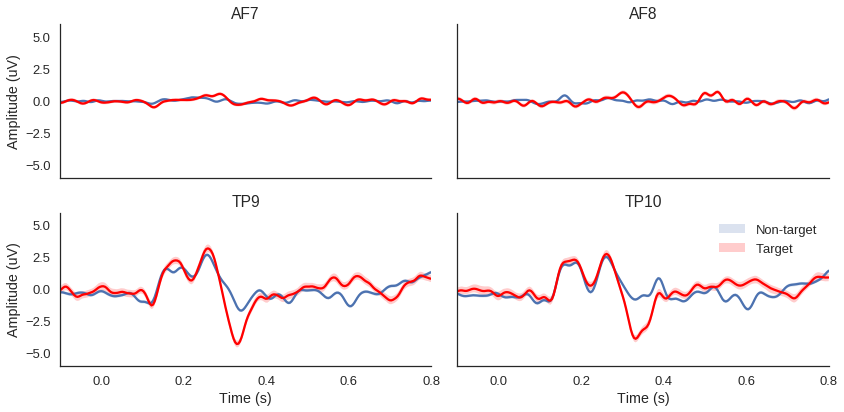

In [3]:
from mne.epochs import concatenate_epochs
epochs = concatenate_epochs(all_epochs)
epochs.pick_types(eeg=True)
X = epochs.get_data()*1e6
times = epochs.times
y = epochs.events[:, -1]

sns.set_context('talk')
sns.set_style('white')
fig, axes = plt.subplots(2,2, figsize=[12,6], sharex=True, sharey=True)
axes = [axes[1, 0], axes[0, 0], axes[0, 1], axes[1, 1]]

for ch in range(4):
    sns.tsplot(X[y==1, ch], time=times, n_boot=1000, ax=axes[ch])
    sns.tsplot(X[y==2, ch], time=times, color='r',  n_boot=1000, ax=axes[ch])
    axes[ch].set_title(epochs.ch_names[ch])
    axes[ch].set_ylim(-6, 6)

axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude (uV)')
axes[-1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude (uV)')
plt.legend(['Non-target', 'Target'])
sns.despine()
plt.tight_layout()


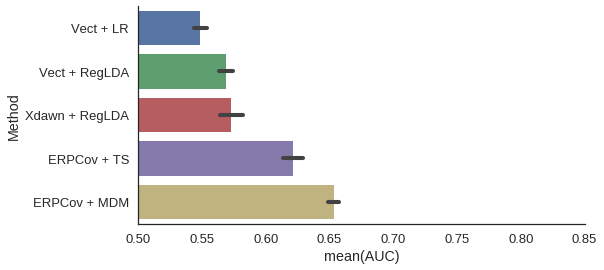

In [4]:
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, LeaveOneGroupOut

from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.spatialfilters import Xdawn

from collections import OrderedDict

clfs = OrderedDict()

clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(4, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())

X = [epochs.copy().pick_types(eeg=True).get_data() for epochs in all_epochs]
y = [epochs.events[:, -1] for epochs in all_epochs]
subjects = [[ii]*len(x) for ii, x in enumerate(X)]

X = np.concatenate(X)
y = np.concatenate(y)
subjects = np.concatenate(subjects)


# define cross validation 
cv = LeaveOneGroupOut()

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==2, groups=subjects, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.5, 0.85)
sns.despine()